# Introduction to Reproducible Research with R
## Lab 01 for PH 290: Targeted Learning in Biomedical Big Data
### Author: [Nima Hejazi](https://nimahejazi.org)
### Date: 16 January 2017
### Attribution: adapted from source materials by [David Benkeser](https://github.com/benkeser)

## I. Introduction

This document provides a brief introduction to a few of the core constructs of the `R` language and environment for statistical computing. These will be necessary for the first laboratory assignment and will be staples that you will rely on throughout the course.

In [52]:
options(repr.plot.width = 4, repr.plot.height = 3)  ## resizing plots
options(scipen = 999)  ## has scientific notation ever annoyed you?

In [54]:
# packages for project management
library(usethis)  # commonly used package components
library(here)  # set paths relative to a .Rproj file


Attaching package: ‘usethis’

The following objects are masked from ‘package:devtools’:

    use_appveyor, use_build_ignore, use_code_of_conduct, use_coverage,
    use_cran_badge, use_cran_comments, use_data, use_data_raw,
    use_dev_version, use_git, use_git_hook, use_github,
    use_github_links, use_gpl3_license, use_mit_license, use_news_md,
    use_package, use_package_doc, use_rcpp, use_readme_md,
    use_readme_rmd, use_revdep, use_rstudio, use_test, use_testthat,
    use_travis, use_vignette

here() starts at /Users/nimahejazi/Dropbox/UC_Berkeley-grad/teaching/tlbbd-labs/lab_01


Let's take a moment to see why we'd use something like `here`:
* https://twitter.com/hadleywickham/status/940021008764846080

While `usethis` is not a necessity (unlike `here`), it does make life _a lot_ easier
* https://github.com/r-lib/usethis

In [1]:
# some more data-oriented packages we'll use
library(tidyverse)  ## core tools for "tidy" data science
library(skimr)  ## take a deeper look at your data


Attaching package: ‘skimr’

The following objects are masked from ‘package:dplyr’:

    contains, ends_with, everything, matches, num_range, one_of,
    starts_with



## II. Simulating data

A big part of what we statisticians do is based on simulating data. You just came up with a method that, in theory, is brilliant/elegant/the-best-thing-since-sliced-bread, but you need to illustrate that the method actually works well in practice. For example, your theoretical results may be based on the assumption of a large sample size and you want to investigate how well the method performs when the sample size is modestly small. Providing such information can help convince readers that your method is in fact a good idea. Simulations can also be helpful for showing when a method breaks down, which is something reviewers also like to see. 

To accomplish these tasks, we need to create a data generating experiment where we know the truth so that we can benchmark our method by it. Let's start with a very simple example. Our simulated experiment enrolls `n=100` subjects and measures an outcome $Y$ on each subject. Suppose that we want to know how our method performs when $Y \sim N(0,1)$. 

In [3]:
# we're simulating -- it's important to set the seed for the PRNG
set.seed(3724591)  ## note something like '5' is a BAD seed, it might be worth reading about PRNGs

# simulate 100 draws from a normal distribution.
Y <- rnorm(n = 100, mean = 0 , sd = 1)

# we'll use skimr::skim to take a look at y
skim(Y)

type,stat,level,value,formatted,variable
numeric,missing,.all,0.00000000,0,Y
numeric,complete,.all,100.00000000,100,Y
numeric,n,.all,100.00000000,100,Y
numeric,mean,.all,-0.13230679,-0.13,Y
numeric,sd,.all,1.02838232,1.03,Y
numeric,p0,.all,-2.27469359,-2.27,Y
numeric,p25,.all,-0.78641356,-0.79,Y
numeric,median,.all,-0.07902102,-0.079,Y
numeric,p75,.all,0.62299759,0.62,Y
numeric,p100,.all,1.97201608,1.97,Y


The above code chunk illustrates several important `R` functions.

* First is `rnorm`, which simulates `n` observations from a standard Normal distribution with `mean = 0` and standard deviation `sd = 1`.
* We also illustrated several functions that are useful for ensuring that the data were created properly.
* The function `skim` from the [`skimr` package](https://cran.r-project.org/web/packages/skimr/index.html) provides a catch-all way to take a look at some important properties of a data set (in this case, just a vector). We can see that we received information about the quantiles (just like `summary` would provide), in addition to missingness/completeness, and even a histogram!

Now, let's move on to visualizing our data. We'll do this with `ggplot2`, a modern graphics engine that is an implementation of the [Grammar of Graphics](http://vita.had.co.nz/papers/layered-grammar.pdf).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


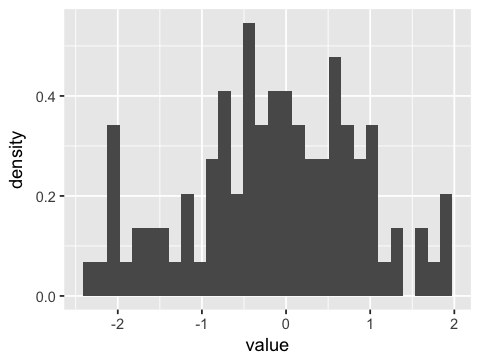

In [14]:
# let's take a closer look at the histogram of Y
p1 <- gather(as_tibble(Y)) %>%
  ggplot(., aes(x = value)) +
  geom_histogram(aes(y = ..density..))
p1

Ok, so there's a lot going on above. Let's take a moment to dissect it. The `ggplot2` engine requires that we pass in a table of ["tidy" data](http://vita.had.co.nz/papers/tidy-data.pdf).

What's tidy data?
1. each observation in a single row
2. each variable in a single column
3. each value in a cell.

To tidy up our data, we can use the `gather` function from the [`tidyr` package](http://tidyr.tidyverse.org/).

Some questions:
* Really, are you kidding? What's a [`tibble`](http://tibble.tidyverse.org/)? It's just a cleaner implementation of a `data.frame`. There's a few re-implementations of this core object because of inefficiencies. Another is the very useful [`data.table`](https://github.com/Rdatatable/data.table/wiki).
* What's this "`%>%`" thing all about? It's a "pipe" operator, introduced initially by the [`magrittr` package](https://cran.r-project.org/web/packages/magrittr/index.html). We'll come back to this.

How does `ggplot2` work?
* We're composing a plot in _layers_.
* First, we add a core data layer: this is the `tibble` that is passed in by the pipe. With `aes`, we specify that the x-axis of our plot is going to be the variable `value` (n.b., this is created implicitly by `tidyr::gather`).
* Next, we specify the type of plot -- we're making a histogram, hence the use of the aptly named `geom_histogram`. By specifying `aes` here, we note that the y-axis is going to be a density (we could have also done `aes(y = ..counts..)`.
* We could just stop here, but there's more we can do to improve our plot.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


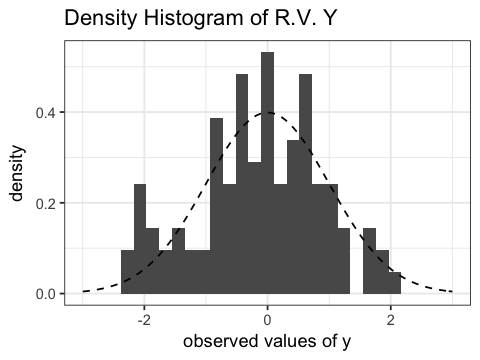

In [18]:
p2 <- p1 +
  stat_function(fun = dnorm, args = list(mean = 0, sd = 1),
                linetype = "dashed") +  ## let's add a normal distribution to compare our histogram to
  xlim(c(-3, 3)) +  ## we'll set hard limits to the x-axis to make the visualization clearer
  xlab("observed values of y") + ## labeling our axes never hurts
  ggtitle("Density Histogram of R.V. Y") +  ## titles are good too...
  theme_bw()  ## let's get rid of that annoying gray background
p2

Much nicer! Definitely a nicer looking plot than we saw before.

* Consult the comments in the above block to know what each step of the layering does
* Note that we simple constructed a new plot (`p2`) by adding layers to the first plot (`p1`) -- both are preserved!

Alright, now that we've taken a look at `ggplot2` and some other core tools of the [Tidyverse](https://www.tidyverse.org/), let's resume talking about simulations:

There are other distributions we might want to simulate from as well.

In [24]:
# simulate 100 draws from a uniform(0,1) distribution
Y_unif <- runif(n = 100, min = 0, max = 1)

# simulate 100 draws from a bernoulli(0.5) distribution
# recall that a bernoulli(p) distribution is just a binomial(n=1, p)
Y_bern <- rbinom(n = 100, size = 1, prob = 0.5)

# simulate 100 draws from a gamma(1,2) distribution
Y_gamma <- rgamma(n = 100, shape = 1, scale = 2)

# Let's skim these
y_rv <- as_tibble(list(unif = Y_unif, bern = Y_bern, gamma = Y_gamma))
skim(y_rv)

variable,type,stat,level,value,formatted
unif,numeric,missing,.all,0.00000000,0
unif,numeric,complete,.all,100.00000000,100
unif,numeric,n,.all,100.00000000,100
unif,numeric,mean,.all,0.49401894,0.49
unif,numeric,sd,.all,0.25992231,0.26
unif,numeric,p0,.all,0.02287295,0.023
unif,numeric,p25,.all,0.30916221,0.31
unif,numeric,median,.all,0.47026868,0.47
unif,numeric,p75,.all,0.70735798,0.71
unif,numeric,p100,.all,0.99970650,1


`R` has several other functions for simulating data from various distributions. Additionally many packages have been constructed for simulating data from other distributions. Googling "how to simulate from XYZ distribution" will likely be sufficient to figure what package/functions you will need. 

Often, our experiment measures more than a single variable on each unit, so we might want to write a function that returns `n` copies of $O = (W,A,Y)$. Suppose that $O$ is distributed as follows

$$ W \sim Uniform(0,1) $$
$$ A \sim Bernoulli(expit[-1 + W]) $$
$$ Y \sim Normal(W + A, 1/2) $$

We can now write a function that takes as input `n` and returns a `data.frame` object with rows corresponding to observations $O$ and columns corresponding to $W, A, Y$.

In [25]:
# define a function that takes as input n (a numeric)
make_data_O <- function(n) {
    W <- runif(n, min = 0, max = 1)
    # plogis is the pdf of the logistic distribution and 
    # plogis(x) = expit(x) = exp(x)/(1+exp(x))
    A <- rbinom(n, size = 1, prob = plogis(-1 + W))
    Y <- rnorm(n, mean = W + A, sd = sqrt(1/2))
    
    # return a data.frame object with named columns W, A, Y
    return(as_tibble(list(W = W, A = A, Y = Y)))
}

# make a data set with 100 observations
data_O_obs <- make_data_O(n = 100)

# confirm that make_data_O() returned a tibble object
class(data_O_obs)

[1] "tbl_df"     "tbl"        "data.frame"

In [26]:
# let's skim over the observed data
skim(data_O_obs)

variable,type,stat,level,value,formatted
W,numeric,missing,.all,0.000000000,0
W,numeric,complete,.all,100.000000000,100
W,numeric,n,.all,100.000000000,100
W,numeric,mean,.all,0.508036909,0.51
W,numeric,sd,.all,0.287817470,0.29
W,numeric,p0,.all,0.008145839,0.0081
W,numeric,p25,.all,0.262854320,0.26
W,numeric,median,.all,0.519560866,0.52
W,numeric,p75,.all,0.736241402,0.74
W,numeric,p100,.all,0.997624422,1


Notice that in our function, we specified the vector `W` as above. However, when we generated `A`, rather than giving the `prob` argument of the `rbinom` function a numeric, we gave it a vector `plogis(-1 + W)`. The function is smart enough to know that when we give it a scalar argument for `size`, but a vector argument for `prob`, we mean that we want all `n` objects to be random draws from a binomimal distribution with `size = 1`, but whose probabilities vary according to the vector `plogis(-1 + W)`. 

Our function returned a `tibble` object. These objects in `R` can be useful for interfacing with certain functions like `glm`, that we'll meet in a minute (just like the canonical `data.frame`). These objects consist of named vectors of the same length that are stored as columns. Using the `$` operator accesses the a named attribute of the object. In addition, `tibble`s form the core object of the Tidyverse, a useful set of tools with which you should strive to be familiar.

We conclude this section with a quick statement of a fact that may be obvious but bears mention. We have not idiot-proofed the function `make_data_O`. That is, the function expects a numeric input `n` and if we give it something crazy, the results will be unexpected. We can see this like so

In [27]:
make_data_O(n = "something crazy")

Warning message in runif(n, min = 0, max = 1):
“NAs introduced by coercion”

ERROR: Error in runif(n, min = 0, max = 1): invalid arguments


Above, the function tried to pass the character object `n` into `runif`, which threw an error. If only you will ever use your function, it may not be worth your time to include sanity checks; however, if others will use your function, it's (usually) worth it to build in some checks of function inputs and throw errors if input is unexpected. Here's an example:

In [29]:
# define a function that takes as input n (a numeric)
make_sane_data_O <- function(n){
    # check whether n is of class numeric
    if(class(n) != "numeric"){
        stop("n is not numeric. Can't simulate data.")
    }
    W <- runif(n, min = 0, max = 1)
    # plogis is the pdf of the logistic distribution and 
    # plogis(x) = expit(x) = exp(x)/(1+exp(x))
    A <- rbinom(n, size = 1, prob = plogis(-1 + W))
    Y <- rnorm(n, mean = W + A, sd = sqrt(1/2))
    
    # return a data.frame object with named columns W, A, Y
    return(as_tibble(list(W = W, A = A, Y = Y)))
}

In [30]:
make_sane_data_O(n = "something crazy")

ERROR: Error in make_sane_data_O(n = "something crazy"): n is not numeric. Can't simulate data.


### Resources:
* [_R for Reproducible Scientific Analysis_ (Software Carpentry)](https://swcarpentry.github.io/r-novice-gapminder/)
* [Tools for Reproducible Research (Karl Broman, UW-Madison)](http://kbroman.org/Tools4RR/)
* [_Version Control with git_ (Software Carpentry)](https://swcarpentry.github.io/git-novice/)
* [_Happy git and GitHub for the userR_ (Jenny Bryan)](http://happygitwithr.com/)
* [git for Humans (Alice Bartlett)](https://speakerdeck.com/alicebartlett/git-for-humans)
* [Introduction to git (Berkeley Stat 259, KJ Millman)](http://www.jarrodmillman.com/rcsds/standard/git-intro.html)
* [Interactive git Tutorial (GitHub)](https://try.github.io/levels/1/challenges/1)

### Appendix: Ceci n'est pas une pipe.

* See http://r4ds.had.co.nz/pipes.html

---

# Introduction to GLMs in R
## Lab 02 for PH 290: Targeted Learning in Biomedical Big Data
### Author: [Nima Hejazi](https://nimahejazi.org)
### Date: 17 January 2017
### Attribution: adapted from source materials by [David Benkeser](https://github.com/benkeser)

## III. Fitting basic GLMs

The first lab assignment asks you to fit several [generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model). A generalized linear model for an observation $O=(W,A,Y)$ assumes that the conditional distribution of $Y$ given $A, W$ has some parameteric distribution (typically one from the Exponential Family) and that the conditional mean of $Y$ given $A,W$ can be written as

$$ g[E(Y | A, W)] = \beta_0 + \beta_1 A + \beta_2 W  \ . $$

There is typically a choice of the link function $g()$ that is associated with a particular parametric family; this is known as the canonical link function. For example, when $Y \in \{0,1\}$ we assume that $Y$ is Bernoulli distribution with $g(x) = log[x/(1-x)]$ -- also known as the logit link function. `R` has so-called `family` objects built in that can identify these relationships.

In [35]:
# for logisitic regression
binomial()
# for linear regression
gaussian()
# for poisson regression
poisson()
# for Gamma regression (make sure G is capital!)
Gamma()


Family: binomial 
Link function: logit 



Family: gaussian 
Link function: identity 



Family: poisson 
Link function: log 



Family: Gamma 
Link function: inverse 


The unknown parameters of a GLM are typically estimated via maximum likelihood, which can be achieved in `R` through the use of the `glm` function. Below, we illustrate a couple different ways to call `glm`. 

In [37]:
# we'll use our data.frame object dat from before to fit the
# linear regression Y = \beta_0 + \beta_1 A + \beta_2 W

# first we can specify a formula and a data.frame object
mod_1 <- data_O_obs %>%
  glm(formula = "Y ~ A + W", data = ., family = gaussian())

# check the class
class(mod_1)

# summarize the results
summary(mod_1)

[1] "glm" "lm"


Call:
glm(formula = "Y ~ A + W", family = gaussian(), data = .)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.51390  -0.44471  -0.03176   0.39016   1.61826  

Coefficients:
            Estimate Std. Error t value          Pr(>|t|)
(Intercept)   0.1817     0.1343   1.353            0.1792
A             1.2030     0.1395   8.626 0.000000000000123
W             0.7022     0.2323   3.023            0.0032

(Dispersion parameter for gaussian family taken to be 0.4217676)

    Null deviance: 82.880  on 99  degrees of freedom
Residual deviance: 40.911  on 97  degrees of freedom
AIC: 202.41

Number of Fisher Scoring iterations: 2


How about logistic regression this time? We'll need new data though...

In [38]:
# define a function that takes as input n (a numeric)
# and returns n copies of O=(W, A, Y) where Y \in \{0,1\}
make_binary_O <- function(n) {
    W <- runif(n, min = 0, max = 1)
    # plogis is the pdf of the logistic distribution and 
    # plogis(x) = expit(x) = exp(x)/(1+exp(x))
    A <- rbinom(n, size = 1, prob = plogis(-1 + W))
    # now Y is binary
    Y <- rbinom(n, size = 1, prob = plogis(-1 + W + A))
    
    # return a data.frame object with named columns W, A, Y
    return(as_tibble(list(W = W, A = A, Y = Y)))
}

In [42]:
# generate the data and fit logistic regression
binary_O <- make_binary_O(n = 100)

# remember, we need family = binomial for logistic regression
mod_2 <- binary_O %>%
  glm("Y ~ A + W", data = ., family = binomial())

# summarize the model output
summary(mod_2)


Call:
glm(formula = "Y ~ A + W", family = binomial(), data = .)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3282  -0.8670  -0.7749   1.1608   1.7023  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  -1.2185     0.4602  -2.648   0.0081
A             0.9839     0.4310   2.282   0.0225
W             0.6116     0.7424   0.824   0.4101

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 132.81  on 99  degrees of freedom
Residual deviance: 126.20  on 97  degrees of freedom
AIC: 132.2

Number of Fisher Scoring iterations: 4


The method `summary.glm` returns Wald-style tests that the estimated regression parameters are equal to zero. Let\'s figure out how to access those values.

To access these values, we can look inside the model object like so

In [43]:
objects(mod_2)

[1] "aic"               "boundary"          "call"             
 [4] "coefficients"      "contrasts"         "control"          
 [7] "converged"         "data"              "deviance"         
[10] "df.null"           "df.residual"       "effects"          
[13] "family"            "fitted.values"     "formula"          
[16] "iter"              "linear.predictors" "method"           
[19] "model"             "null.deviance"     "offset"           
[22] "prior.weights"     "qr"                "R"                
[25] "rank"              "residuals"         "terms"            
[28] "weights"           "xlevels"           "y"

In [44]:
## looks like we might want "coefficients"
mod_2$coefficients

(Intercept)           A           W 
 -1.2184733   0.9838565   0.6115770

## IV. Simulation basics
We now have all the components we need to execute a basic simulation. In frequentist statistics, we care a lot about what happens to a given summary measure of data (i.e., a statistic) over repeated experiments. Whereas in real life, we typically only get data from one or two repeated experiments where we don't know the real answer, in simulations we can generate many, many experiments where we do know the answer. 

Suppose we are interested in the power of a statistical test. That is, if the null hypothesis is not true, what is the probability (i.e., proportion of times over repeated experiments) that we correctly reject the null hypothesis. Below, we define a couple functions that we will combine into a function that executes one simulation (i.e., one analysis for one data set).

In [46]:
# a function that takes as input 'fm', a glm object and returns whether
# or not the p-value for the coefficient associated with A is 
# rejected at the 0.05 level
is_null_rejected <- function(fm) {
    sumFm <- summary(fm)
    p_val <- sumFm$coefficients["A","Pr(>|z|)"]
    return(p_val < 0.05)
}


# a function that takes as input 'n', a scalar, simulates a data set
# using makeBinaryO, estimates a main-terms glm and determines whether 
# the coefficient associated with A is rejected at the 0.05 level
run_one_sim <- function(n) {
    # make data set
    dat <- make_binary_O(n = n)
    # fit glm
    fm <- glm("Y ~ A + W", data = dat, family = binomial())
    # get hypothesis test result
    out <- is_null_rejected(fm)
    # return
    return(out)
}

# try it out
run_one_sim(n = 100)

[1] TRUE

Now we need to do this a large number of times. There are many ways to do this, a couple illustrated below. First, we start with a basic `for` loop.

In [49]:
# number of simulations, in general more is better to decrease
# the Monte Carlo error in your answer (i.e., error due to random seed used)
n_sim <- 100

# let's set a seed so the results are reproducible
set.seed(1234)

## get results using a for() loop
# create empty vector of length nSim that results will go into
results_vector <- rep(NA, n_sim)
for(i in seq_len(n_sim)){
    results_vector[i] <- run_one_sim(n = 100)
}

# check out first and last results
head(results_vector) 
tail(results_vector)

# power is the average number of times you reject the null
cat("The power of the test is " , mean(results_vector))

[1]  TRUE FALSE  TRUE  TRUE FALSE  TRUE

[1] FALSE  TRUE  TRUE  TRUE FALSE  TRUE

The power of the test is  0.58

Next we use `R`'s built in function `replicate`. This function repeatedly evaluates `expr` a total of `n` times and stores the output. It's exactly like a `for` loop, but with shorter syntax. 

In [51]:
# again set a seed so reproducible
set.seed(1234)
# replicate
results_rep <- replicate(n = n_sim, expr = run_one_sim(n = 100))

cat("The power of the test is " , mean(results_rep))

The power of the test is  0.58